<a href="https://colab.research.google.com/github/2020KUCP1104/Abhi1104/blob/main/Movie_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries:

In [7]:
import os

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Loading Data and Data Cleaning:

In [9]:
Movie_rating = pd.read_csv("Movie.csv", encoding="latin1")

In [10]:
#Drop unnecessary columns
Movie_rating.drop(['Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], axis=1, inplace=True)


In [11]:
# Fill missing values in 'Rating' column with mean rating
Movie_rating['Rating'].fillna(Movie_rating['Rating'].mean(), inplace=True)

In [12]:
# Convert 'Votes' column to numeric and fill missing values with mean
Movie_rating['Votes'] = pd.to_numeric(Movie_rating['Votes'], errors='coerce')
Movie_rating['Votes'].fillna(Movie_rating['Votes'].mean(), inplace=True)

In [13]:
# Convert 'Year' column to numeric, fill missing values with 0, and make all values positive
Movie_rating['Year'] = pd.to_numeric(Movie_rating['Year'], errors='coerce')
Movie_rating['Year'].fillna(0, inplace=True)
Movie_rating['Year'] = Movie_rating['Year'].abs()

#Data Transformation:

In [14]:
# Function to extract numeric part from 'Duration' column
def extract_numeric_duration(data):
    return data.str.extract(r'(\d+)').astype(float)

In [15]:
# Create dummy variables for genres and concatenate them with the main DataFrame
genres = Movie_rating['Genre'].str.get_dummies(', ')
Movie_rating = pd.concat([Movie_rating, genres], axis=1)
Movie_rating.drop('Genre', axis=1, inplace=True)

#Feature Engineering and Preprocessing:

In [16]:
# Separate features and target variable
X = Movie_rating.drop('Rating', axis=1)
y = Movie_rating['Rating']

In [17]:
# Extract numeric part from 'Duration' column and fill missing values with 0
X['Duration'] = X['Duration'].apply(lambda row: 0 if str(row) == 'nan' else float(row.split(" min")[0]))
X.fillna(0, inplace=True)

In [18]:
X.head()

,Year,Duration,Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0.0,0.0,120.839493,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,109.0,8.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,90.0,120.839493,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,110.0,35.000000,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.0,105.0,120.839493,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Splitting Data:

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Defining Transformers and Preprocessor:

In [20]:
# Define numeric features
numeric_features = ['Year', 'Duration', 'Votes']
#Create pipelines for preprocessing numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [21]:
# Define categorical features
categorical_features = ['Drama', 'Musical', 'Comedy', 'Romance', 'War', 'Documentary', 'Horror', 'Mystery', 'Thriller', 'Action', 'Crime']
#Create pipelines for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
# Combine the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Defining the Model Pipeline:

In [23]:
# Define the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

#Defining Parameter Grid for Grid Search:

In [24]:
# Define the parameter grid for grid search
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

#Performing Grid Search with Cross-Validation:

In [25]:
# Perform grid search with cross-validation
try:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)
except Exception as e:
    print("An error occurred during grid search:", e)


Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


In [26]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


#Model Evaluation:

In [27]:
# Make predictions on the test set
y_pred = grid_search.predict(X_test)

In [28]:
# Calculate test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 0.9059265709682807


#Feature Importance Visualization:

In [29]:
# Get feature importances from the best estimator
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = numeric_features + list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out())
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

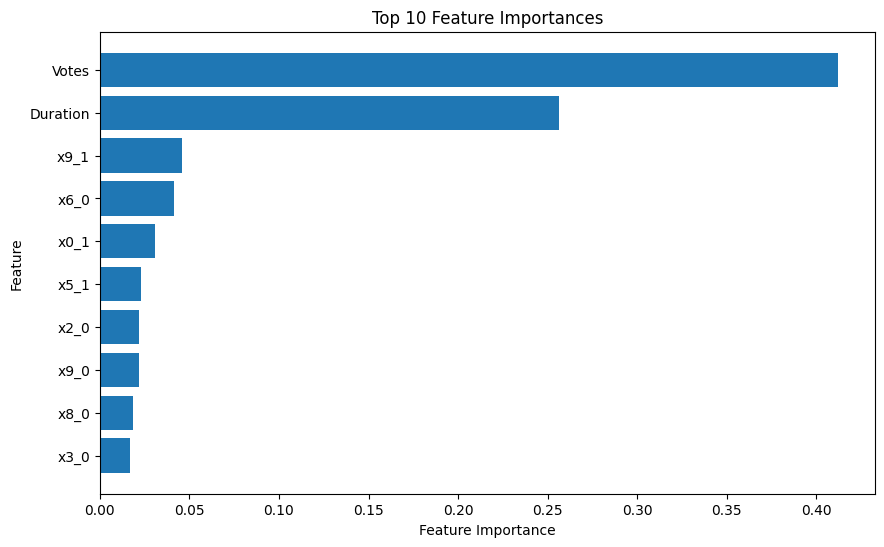

In [30]:
# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

#Visualization of Movie Ratings Distribution:

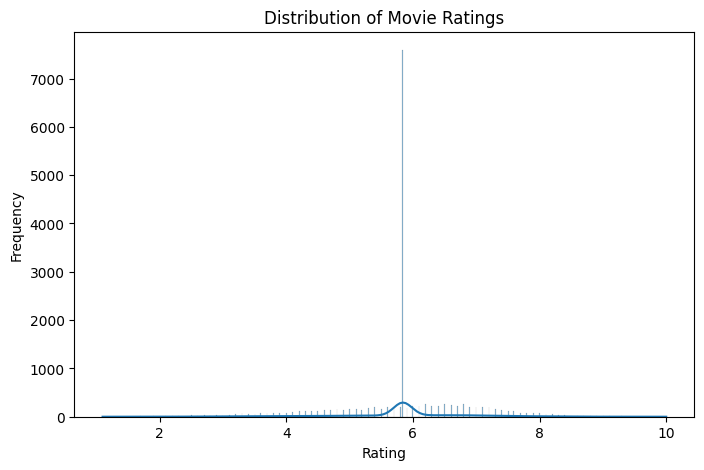

In [31]:
# Plot the distribution of movie ratings
plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

#Visualization of Counts of Different Genres:

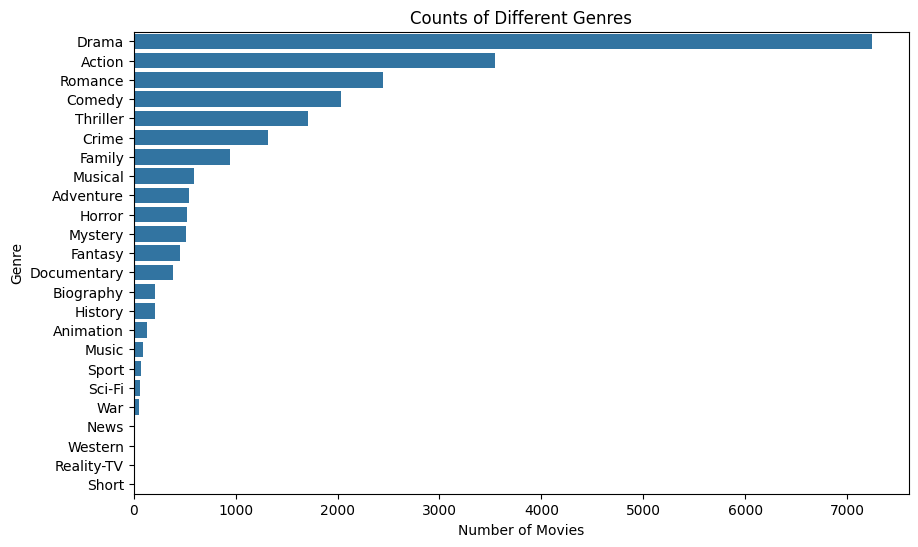

In [32]:
# Plot the counts of different genres
genre_counts = genres.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Counts of Different Genres")
plt.show()

#Visualization of Movie Durations Distribution:

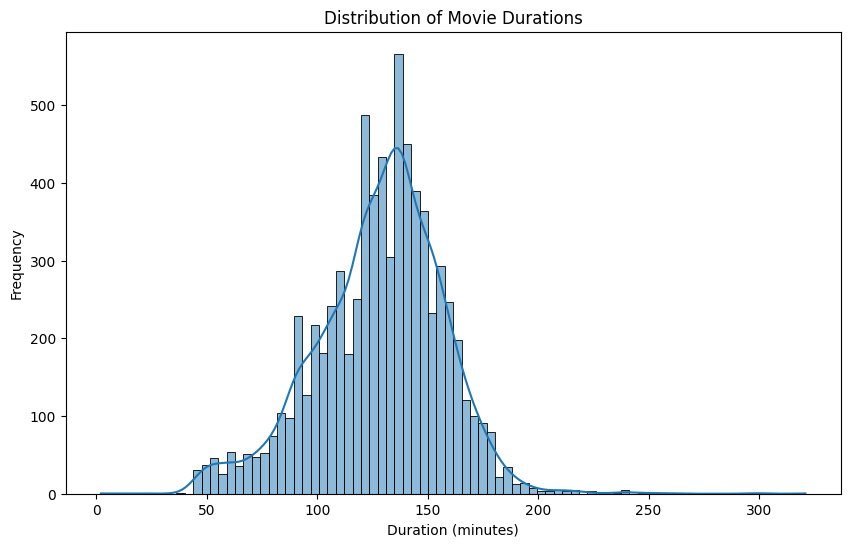

In [33]:
# Filter out movies with duration 0 or no value
valid_durations = X[X['Duration'] > 0]['Duration']

# Plotting the distribution of movie durations
plt.figure(figsize=(10, 6))
sns.histplot(valid_durations, kde=True)
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Durations")
plt.show()




#Filtering out Movies with Undefined Genre Information and Genre Combinations:

In [45]:

# Concatenate genre columns to create a new column 'Genre_combination'
Movie_rating['Genre_combination'] = Movie_rating[categorical_features].apply(lambda row: ', '.join(row.index[row == 1]), axis=1)

# Filter out rows with missing or undefined genre information
defined_genre_movies = Movie_rating[Movie_rating['Genre_combination'] != '']

# Count occurrences of each genre combination
defined_genre_counts = defined_genre_movies['Genre_combination'].value_counts()

# Create a DataFrame for the top 10 most common genre combinations
top_genre_combinations = pd.DataFrame(defined_genre_counts.head(10).reset_index())
top_genre_combinations.columns = ['Genre Combination', 'Number of Movies']

# Display the top 10 most common genre combinations in tabular form
print("Top 10 most common genre combinations (excluding undefined genres):")
print(top_genre_combinations.to_string(index=False))


Top 10 most common genre combinations (excluding undefined genres):
   Genre Combination  Number of Movies
               Drama              3493
              Action              1414
            Thriller               788
             Romance               748
      Drama, Romance               636
              Comedy               539
       Drama, Action               502
Drama, Action, Crime               462
       Drama, Comedy               426
         Documentary               338


#Plotting the Top 10 Most Common Genre Combinations:

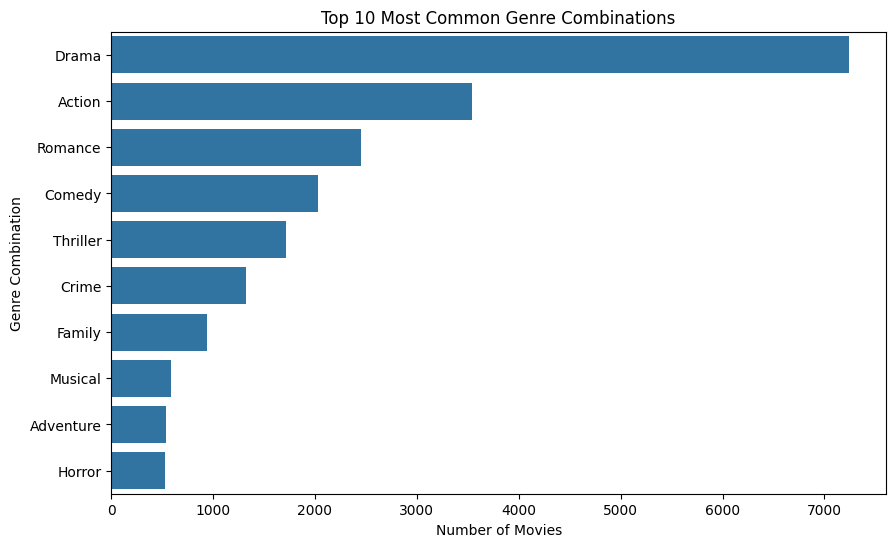

In [37]:
# Plotting the top 10 most common genre combinations
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index)
plt.xlabel("Number of Movies")
plt.ylabel("Genre Combination")
plt.title("Top 10 Most Common Genre Combinations")
plt.show()


#Cross-validated RMSE Calculation:

In [38]:
# Perform cross-validation to assess model performance
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validated RMSE:", cv_rmse)

Cross-validated RMSE: [0.87075082 0.93944316 0.92906119 0.92201975 0.92864169]


#Saving the Trained Model:

In [39]:
# Save the trained model
joblib.dump(grid_search.best_estimator_, 'movie_rating_model.pkl')

['movie_rating_model.pkl']

#Making Predictions for a New Movie:

In [40]:
# Create a DataFrame for a new movie
new_movie = pd.DataFrame({
        'Year': [2024],
        'Duration': [120],
        'Votes': [5000],
        'Drama': [1],
        'Musical': [0],
        'Comedy': [1],
        'Romance': [0],
        'War': [0],
        'Documentary': [0],
        'Horror': [0],
        'Mystery': [1],
        'Thriller': [1],
        'Action': [0],
        'Crime': [0]
    })
predicted_rating = grid_search.predict(new_movie)
print("Predicted Rating for the new movie:", predicted_rating[0])

Predicted Rating for the new movie: 5.496302265705769
